When we hear our native language, we intuitively know the meaning of what we heard. However, many people who've tried to learn a second or third language find the process to be much more painful. They have to break the language down into components like tenses in order to understand it better. Many have to take years of language lessons to get to the point where they can have a conversation.

Learning a language is difficult because language has many complex rules. If we want computers to be able to understand language, we either need to explicitly teach computers the rules, or enable the computers to intuit the rules themselves. The former is a lot like learning a second language, and the latter is a lot like learning our native language.

Broadly speakingly, natural language processing is the study of enabling computers to understand human languages. This field may involve teaching computers to automatically score essays, infer grammatical rules, or determine the emotions associated with text.

In this project, we'll learn some of the basic building blocks of natural langage processing. When we feed a computer written text, it has no idea what that text means. In order for a computer to begin making inferences from it, we'll need to convert the text to a numerical representation. This process will enable the computer to intuit grammatical rules, which is more akin to learning a first language.

We'll explore how to get from written text to a numerical representation, and how we can use that representation to make predictions.

[Hacker News](https://news.ycombinator.com/) is a community where users can submit articles, and other users can upvote those articles. The articles with the most upvotes make it to the front page, where they're more visible to the community.

Our data set consists of submissions users made to Hacker News from 2006 to 2015. Developer Arnaud Drizard used the Hacker News API to scrape the data, which we can find in [one of his GitHub repositories](https://github.com/arnauddri/hn). We've sampled 3000 rows from the data randomly, and removed all of the extraneous columns. Our data only has four columns:

* submission_time - When the article was submitted
* upvotes - The number of upvotes the article received
* url - The base URL of the article
* headline - The article's headline

In this project, we'll be predicting the number of upvotes the articles received, based on their headlines. Because upvotes are an indicator of popularity, we'll discover which types of articles tend to be the most popular.

In [11]:
import pandas as pd
submissions = pd.read_csv("sel_hn_stories.csv")
print(submissions.columns)
submissions.columns = ["submission_time", "upvotes", "url", "headline"]
submissions = submissions.dropna()

Index(['2014-06-24T05:50:40.000Z', '1', 'flux7.com',
       '8 Ways to Use Docker in the Real World'],
      dtype='object')


Our goal is to train a linear regression algorithm that predicts the number of upvotes a headline would receive. To do this, we'll need to convert each headline to a numerical representation.

While there are several ways to accomplish this, we'll use a [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model). A bag of words model represents each piece of text as a numerical vector.

Here's a high-level diagram showing how two sentences, **I rode my horse to Berlin**. and **You rode my horse to Berlin in the winter.**, convert to a bag of words:

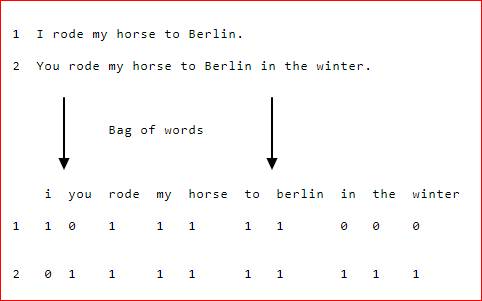

The first step in creating a bag of words model is [tokenization](https://en.wikipedia.org/wiki/Tokenization). In tokenization, we break a sentence up into disconnected words.

Here's a diagram in which we tokenize the two sentences we mentioned above:

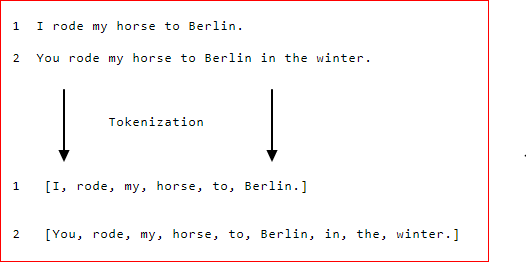

As we can see, all we're doing is splitting each sentence into a list of individual words, or tokens. The split occurs on the space character (" ").

In [12]:
tokenized_headlines = []
for item in submissions["headline"]:
    tokenized_headlines.append(item.split())

We now have tokens, but we need to process them a bit to make our predictions more accurate. We know that Berlin, Berlin., and berlin all refer to the same word, but the computer doesn't know that. We'll need to convert those variations so that they're consistent.

We can do this by lowercasing (which will convert Berlin to berlin), and also by removing punctuation (so Berlin. becomes Berlin).

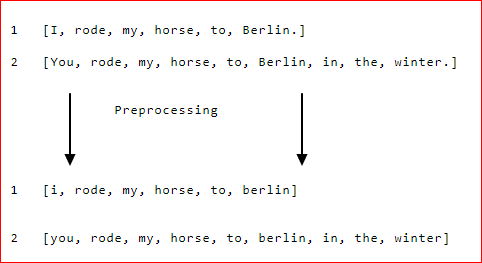

Preprocessing doesn't have to be perfect, but the more we can help the computer group the same word together, the higher our prediction accuracy will be. 

In [13]:
punctuation = [",", ":", ";", ".", "'", '"', "’", "?", "/", "-", "+", "&", "(", ")"]

clean_tokenized = []

for item in tokenized_headlines:
    tokens = []
    for token in item:
        token = token.lower()
        for punc in punctuation:
            token = token.replace(punc,"")
        tokens.append(token)
    clean_tokenized.append(tokens)
        

Now that we have our tokens, we can begin converting the sentences to their numerical representations. First, we'll retrieve all of the unique words from all of the headlines. Then, we'll create a matrix, and assign those words as the column headers. We'll initialize all of the values in the matrix to 0

We'll use a pandas dataframe instead of a NumPy matrix. We can create a dataframe with all zero values

In [14]:
import numpy as np
unique_tokens = []
for item in clean_tokenized:
    for token in item:
        if token not in unique_tokens:
            unique_tokens.append(token)
        else: # not necessary to use else statement. if statement is enough
            continue

In [15]:
len(unique_tokens)

6917

In [16]:
counts = pd.DataFrame(0, index = np.arange(len(clean_tokenized)), columns= unique_tokens)

In [17]:
counts.columns.size

6917

In [18]:
(counts.columns.value_counts()> 1).sum()

0

"0" Shows that, there is no duplicate columns

Now that we have a matrix where all values are 0, we need to fill in the correct counts for each cell. This involves going through each set of tokens, and incrementing the column counters in the appropriate row.

When we're finished, we'll have a row vector for each headline that tells us how many times each token occured in that headline.

In [19]:
for i, item in enumerate(clean_tokenized):
    for token in item:
        counts.loc[i, token] += 1
    

We have over 6900 columns in our matrix. This can make it very hard for a linear regression model to make good predictions. Too many columns will cause the model to fit to noise instead of the signal in the data.

There are two kinds of features that will reduce prediction accuracy. Features that occur only a few times will cause overfitting, because the model doesn't have enough information to accurately decide whether they're important. These features will probably correlate differently with upvotes in the test set and the training set.

Features that occur too many times can also cause issues. These are words like **and** and **to**, which occur in nearly every headline. These words don't add any information, because they don't necessarily correlate with upvotes. These types of words are sometimes called **stopwords**.

To reduce the number of features and enable the linear regression model to make better predictions, we'll remove any words that occur fewer than 5 times or more than 100 times.

In [20]:
# sum of each column in counts
word_counts = counts.sum(axis = 0)
selected_cols = word_counts[(word_counts > 5) & (word_counts < 100)].index.tolist()
selected_cols[:5]

['software', 'we', 'from', 'googles', 'more']

In [21]:
counts = counts[selected_cols]

Now we'll need to split the data into two sets so that we can evaluate our algorithm effectively. 

The [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from scikit-learn will help us accomplish this.

We'll pass in .2 for the test_size parameter to randomly select 20% of the rows for our test set, and 80% for our training set.

X_train and X_test contain the predictors, and y_train and y_test contain the value we're trying to predict (upvotes).

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts, submissions["upvotes"], test_size = 0.2, random_state = 1)

We'll use a linear regression algorithm from scikit-learn. When we make predictions with a linear regression model, the model assigns coefficients to each column. Essentially, the model is determining which words correlate with more upvotes, and which with less. By finding these correlations, the model will be able to predict which headlines will be highly upvoted in the future. While the algorithm won't have a high level of understanding of the text, linear regression can generate surprisingly good results.

In [24]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

In [26]:
mse = sum((predictions - y_test) ** 2) / len(predictions)
mse

2285.628809494208

Because the errors are squared, MSE penalizes errors further away from the actual value more than those close to the actual value. We want to use MSE because we'd like all of our predictions to be relatively close to the actual values.

Our MSE is 2285.62, which is a fairly large value. There's no hard and fast rule about what a "good" error rate is, because it depends on the problem we're solving and our error tolerance.

In [28]:
print(np.sqrt(mse))
print(y_test.mean())
print(y_test.std())

47.80825043331128
9.919642857142858
43.123763811139575


In this case, the mean number of upvotes is 10, and the standard deviation is 43.123. If we take the square root of our MSE to calculate error in terms of upvotes, we get 51.5. This means that our average error is 47.8 upvotes away from the true value. This is higher than the standard deviation, so our predictions are often far off-base.